In [1]:
!pip install torchvision==0.16.0
!pip install seaborn
# 安装后点击上方 Restart the kernal

Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import zipfile

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/torch_npu/utils/path_manager.py:79: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/latest owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/torch_npu/utils/path_manager.py:79: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/8.0.RC1/aarch64-linux/ascend_toolkit_install.info owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/torch_npu/contrib/transfer_to_npu.py:211: Im

In [3]:
# 步骤二：加载数据集
zipfile_path = './mnist.zip'  # 压缩文件的路径
output_path = './'  # 解压后的输出目录
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)
# 2.1 设置参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01
ACTIVATION = 'relu'   # 可选 'relu' 或 'sigmoid'
OPTIMIZER = 'sgd'     # 可选 'adam' 或 'sgd'
DROPOUT = False
device = 'npu'

# 2.2 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2.3 加载训练集和测试集
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=transform,
    download=True
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,
    transform=transform,
    download=True
)

train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# 步骤三：MLP模型的构建
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        activation_layer = nn.ReLU() if ACTIVATION == 'relu' else nn.Sigmoid()
        layers = [
            nn.Flatten(),
            nn.Linear(28*28, 128),
            activation_layer,
        ]
        if DROPOUT:
            layers.append(nn.Dropout(0.5))
        layers += [
            nn.Linear(128, 64),
            activation_layer,
            nn.Linear(64, 10)
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp = MLP().to(device)

In [5]:
# 步骤四：设置损失函数与优化器
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'adam':
    optimizer = optim.Adam(mlp.parameters(), lr=LR)
elif OPTIMIZER == 'sgd':
    optimizer = optim.SGD(mlp.parameters(), lr=LR)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=EPOCH*len(train_loader))

In [6]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    mlp.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{EPOCH}], Loss: {epoch_loss:.4f}')

# 5.2 定义测试函数
def test():
    mlp.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = mlp(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())
    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# 5.3 开始训练和测试
os.makedirs('./output', exist_ok=True)
for epoch in range(EPOCH):
    train(epoch)
    if (epoch + 1) % 2 == 0:
        acc, _, _ = test()
        test_accuracies.append(acc)

Training Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 1/938 [01:13<19:06:12, 73.40s/it]

Training Epoch 1: 100%|█████████▉| 937/938 [01:47<00:00, 32.64it/s] 

Training Epoch 1: 100%|█████████▉| 937/938 [02:00<00:00, 32.64it/s]

Training Epoch 1: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s]


Epoch [1/10], Loss: 0.8698


Training Epoch 2: 100%|██████████| 938/938 [00:27<00:00, 34.66it/s]


Epoch [2/10], Loss: 0.2241


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:  97%|█████████▋| 153/157 [00:11<00:00, 36.88it/s]

Training Epoch 3: 100%|██████████| 938/938 [00:28<00:00, 33.34it/s]


Epoch [3/10], Loss: 0.1313


Training Epoch 4: 100%|██████████| 938/938 [00:27<00:00, 34.52it/s]


Epoch [4/10], Loss: 0.0893


Training Epoch 5: 100%|██████████| 938/938 [00:27<00:00, 34.55it/s]


Epoch [5/10], Loss: 0.0671


Training Epoch 6: 100%|██████████| 938/938 [00:27<00:00, 33.79it/s]


Epoch [6/10], Loss: 0.0523


Training Epoch 7: 100%|██████████| 938/938 [00:27<00:00, 34.18it/s]


Epoch [7/10], Loss: 0.0386


Training Epoch 8: 100%|██████████| 938/938 [00:26<00:00, 35.27it/s]


Epoch [8/10], Loss: 0.0286


Training Epoch 9: 100%|██████████| 938/938 [00:27<00:00, 33.65it/s]


Epoch [9/10], Loss: 0.0211


Training Epoch 10: 100%|██████████| 938/938 [00:27<00:00, 34.42it/s]


Epoch [10/10], Loss: 0.0173


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.02it/s]


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.01it/s]



Final Test Accuracy: 98.04%


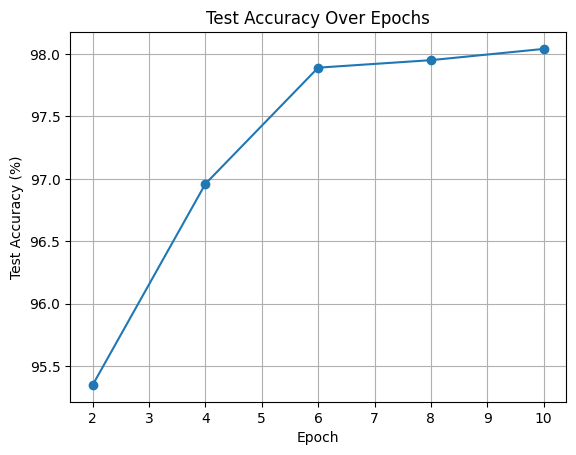

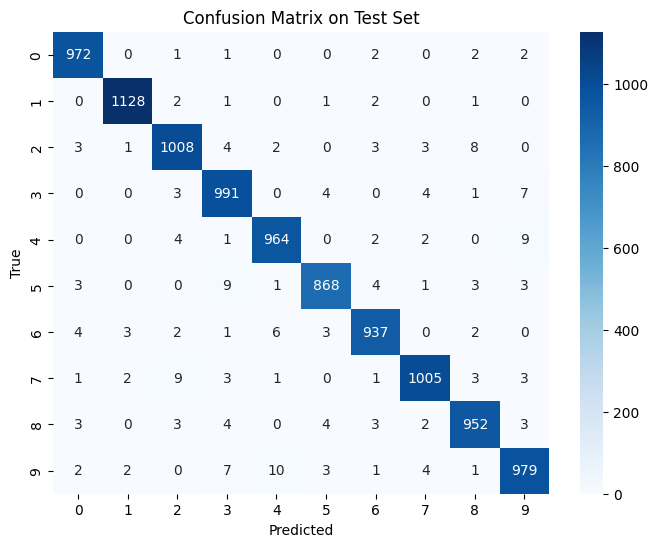

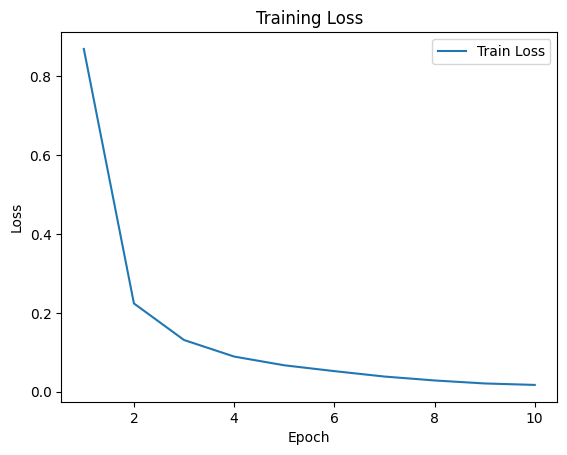

********Prediction Samples********
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
Actual labels:    [7 2 1 0 4 1 4 9 5 9]


In [7]:
# 步骤六：模型评估
# 6.1 最后一次完整测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(2, EPOCH+1, 2), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.savefig('./output/accuracy_curve.png')
plt.show()

# 6.3 绘制混淆矩阵
conf_mat = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.4 绘制训练 loss 曲线图
plt.figure()
plt.plot(range(1, EPOCH+1, 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./output/loss_curve.png')
plt.show()

# 6.5 打印前10个样本预测
print('********Prediction Samples********')
print("Predicted labels:", pred_y[:10].numpy())
print("Actual labels:   ", true_y[:10].numpy())

In [8]:
# 步骤七：保存模型
torch.save(mlp.state_dict(), './output/mlp_model.pth')# 请在此处编写代码：保存模型

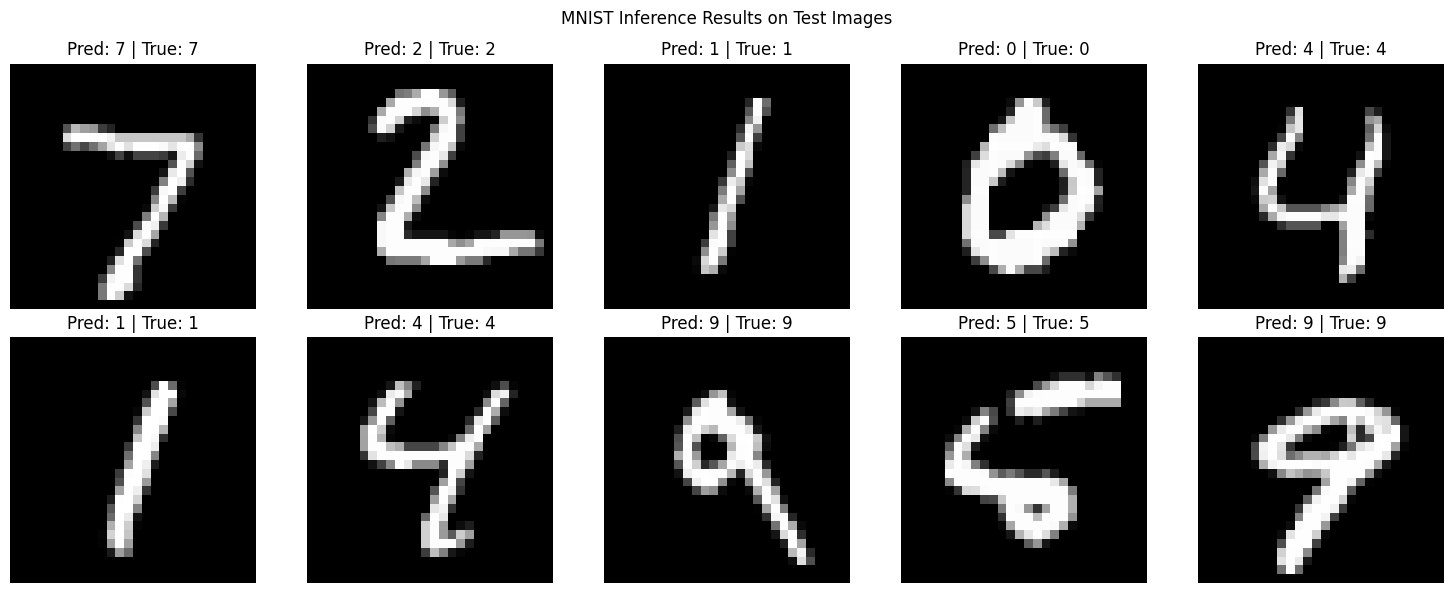

In [9]:
# 步骤八：推理结果可视化（MNIST专用）
def visualize_mnist_predictions(model, test_loader, device='cpu', num_images=10):
    model.eval()
    shown = 0
    plt.figure(figsize=(15,6))
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break
                img = inputs[i].cpu().squeeze().numpy()
                true_label = targets[i].item()
                pred_label = predicted[i].item()
                plt.subplot(2, (num_images+1)//2, shown+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"Pred: {pred_label} | True: {true_label}")
                plt.axis('off')
                shown += 1
            if shown >= num_images:
                break
                
    plt.suptitle("MNIST Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/mnist_test_predictions.png')
    plt.show()


# 调用推理可视化函数
visualize_mnist_predictions(mlp, test_loader, device=device, num_images=10)